In [19]:
import ROOT
import pandas as pd

# Opening the file root format and get the tree
file = ROOT.TFile("signal_file.root")
tree = file.Get("vbf_125_13TeV_THQLeptonicTag")

# Create a pandas DataFrame to hold the data
df = pd.DataFrame()

# branches to include in the CSV file
branch_names = ["ele1_phi","ele1_eta"]

# Fill the DataFrame with data
for entry in tree:
    data = {}
    for name in branch_names:
        data[name] = getattr(entry, name)
    df = df.append(data, ignore_index=True)

# DataFrame to a CSV file
df.to_csv("signal.csv", index=False)

Welcome to JupyROOT 6.26/04


In [20]:
import ROOT
import pandas as pd

# Opening the root file to get the tree
file = ROOT.TFile("background_file.root")
tree = file.Get("ttgg_13TeV_THQLeptonicTag")

# pandas DataFrame to hold the data
df = pd.DataFrame()

# Specify the branches to include in the CSV file
branch_names = ["ele1_phi","ele1_eta"]

# fill the DataFrame with data
for entry in tree:
    data = {}
    for name in branch_names:
        data[name] = getattr(entry, name)
    df = df.append(data, ignore_index=True)

# DataFrame to a CSV file
df.to_csv("background.csv", index=False)

In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score



def electron_gbdt(ln_rt):
# the data
    signal_df = pd.read_csv('signal.csv')
    background_df = pd.read_csv('background.csv')

# assigning boolena logic to signal and background
    signal_df['target'] = 1
    background_df['target'] = 0

# the data combined into a single dataframe
    data_df = pd.concat([signal_df, background_df], ignore_index=True)

# Split the data into training, validation, and testing sets 15% of data for test and 15% for validation
    train_df, test_df = train_test_split(data_df, test_size=0.3, random_state=30)
    val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=30)

# input features and variable
    input_cols = [col for col in data_df.columns if col != 'target']
    target_col = 'target'

# X and y dataframes for training, validation, and testing
    X_train = train_df[input_cols]
    y_train = train_df[target_col]
    X_val = val_df[input_cols]
    y_val = val_df[target_col]
    X_test = test_df[input_cols]
    y_test = test_df[target_col]

# Train
    model = GradientBoostingClassifier(
        n_estimators=50,
        learning_rate=ln_rt,
        max_depth=50,
        random_state=30
    )
    model.fit(X_train, y_train)

# Validate
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    #print(f"Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1-score: {f1:.2f}")

# Test
    y_pred = model.predict(X_test)
    accuracy_gbdt = accuracy_score(y_test, y_pred)
    precision_gbdt = precision_score(y_test, y_pred)
    recall_gbdt = recall_score(y_test, y_pred)
    f1_gbdt = f1_score(y_test, y_pred)
    #print(f"Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1-score: {f1:.2f}")
    
    return accuracy_gbdt,precision_gbdt,recall_gbdt,f1_gbdt    

In [25]:
import time
start_time = time.time()


learn_rate=[]
accuracy_array=[]
precision_array=[]
recall_array=[]
f1_array=[]


for i in range(2,101):
    x=i*0.01
    y1_gbdt,y2_gbdt,y3_gbdt,y4_gbdt=electron_gbdt(x)
    learn_rate.append(x)
    accuracy_array.append(y1_gbdt)
    precision_array.append(y2_gbdt)
    recall_array.append(y3_gbdt)
    f1_array.append(y4_gbdt)
    
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

Elapsed time: 1277.85 seconds


In [45]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
def electron_abdt(ln_rt):
# load csv files
    background = pd.read_csv('background.csv')
    signal = pd.read_csv('signal.csv')

# create labels
    data = pd.concat([background, signal])
    labels = np.concatenate([np.zeros(len(background)), np.ones(len(signal))])

# train, validate, and test sets
    train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.15, random_state=30)
    train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.17, random_state=30)

# train the model
    base_clf = DecisionTreeClassifier(max_depth=50)
    clf = AdaBoostClassifier(base_estimator=base_clf, n_estimators=50, learning_rate=ln_rt, random_state=30)
    clf.fit(train_data, train_labels)

#predictions on validation set
    val_pred = clf.predict(val_data)

# performance on validation set
    val_accuracy = accuracy_score(val_labels, val_pred)
    val_precision = precision_score(val_labels, val_pred)
    val_recall = recall_score(val_labels, val_pred)
    val_f1_score = f1_score(val_labels, val_pred)

# predictions on test set
    test_pred = clf.predict(test_data)

# performance on test set
    test_accuracy_ada = accuracy_score(test_labels, test_pred)
    test_precision_ada = precision_score(test_labels, test_pred)
    test_recall_ada = recall_score(test_labels, test_pred)
    test_f1_score_ada = f1_score(test_labels, test_pred)
#print("Validation set - Accuracy: {:.2f}, Precision: {:.2f}, Recall: {:.2f}, F1 Score: {:.2f}".format(val_accuracy, val_precision, val_recall, val_f1_score))
#print("Test set - Accuracy: {:.2f}, Precision: {:.2f}, Recall: {:.2f}, F1 Score: {:.2f}".format(test_accuracy, test_precision, test_recall, test_f1_score))
    return test_accuracy_ada,test_precision_ada,test_recall_ada,test_f1_score_ada 

In [46]:
import time
start_time = time.time()


learn_rate_ada=[]
accuracy_array_ada=[]
precision_array_ada=[]
recall_array_ada=[]
f1_array_ada=[]


for i in range(2,101):
    x=i*0.01
    y1,y2,y3,y4=electron_abdt(x)
    learn_rate_ada.append(x)
    accuracy_array_ada.append(y1)
    precision_array_ada.append(y2)
    recall_array_ada.append(y3)
    f1_array_ada.append(y4)
    
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

Elapsed time: 166.92 seconds


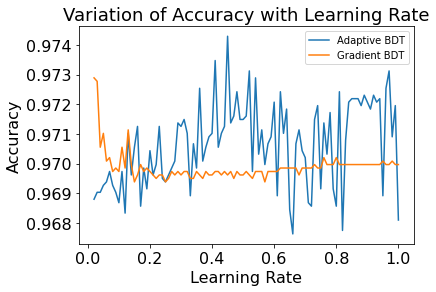

In [47]:
import matplotlib.pyplot as plt
# Plot the data
plt.plot(learn_rate_ada, accuracy_array_ada,label="Adaptive BDT")
plt.plot(learn_rate,accuracy_array,label="Gradient BDT")
# Add axis labels and title
plt.xlabel('Learning Rate', fontname='Times New Roman', fontsize=16)
plt.ylabel('Accuracy', fontname='Times New Roman', fontsize=16)
plt.title('Variation of Accuracy with Learning Rate', fontname='Times New Roman', fontsize=18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend()
# Show the plot
plt.show()

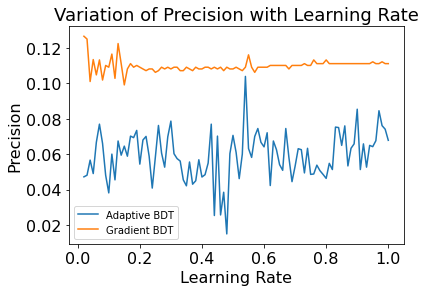

In [52]:
import matplotlib.pyplot as plt
# Plot the data
plt.plot(learn_rate_ada, precision_array_ada,label="Adaptive BDT")
plt.plot(learn_rate,precision_array,label="Gradient BDT")
# Add axis labels and title
plt.xlabel('Learning Rate', fontname='Times New Roman', fontsize=16)
plt.ylabel('Precision', fontname='Times New Roman', fontsize=16)
plt.title('Variation of Precision with Learning Rate', fontname='Times New Roman', fontsize=18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend()
# Show the plot
plt.show()

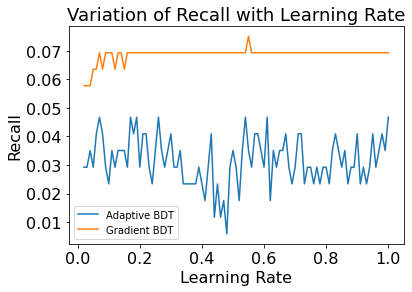

In [54]:
import matplotlib.pyplot as plt
# Plot the data
plt.plot(learn_rate_ada, recall_array_ada,label="Adaptive BDT")
plt.plot(learn_rate,recall_array,label="Gradient BDT")
# Add axis labels and title
plt.xlabel('Learning Rate', fontname='Times New Roman', fontsize=16)
plt.ylabel('Recall', fontname='Times New Roman', fontsize=16)
plt.title('Variation of Recall with Learning Rate', fontname='Times New Roman', fontsize=18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend()
# Show the plot
plt.show()

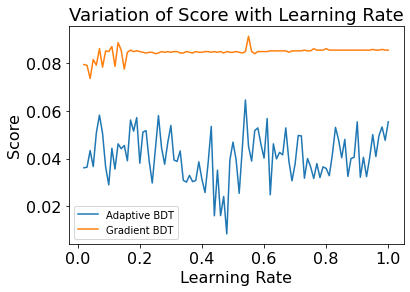

In [55]:
import matplotlib.pyplot as plt
# Plot the data
plt.plot(learn_rate_ada, f1_array_ada,label="Adaptive BDT")
plt.plot(learn_rate,f1_array,label="Gradient BDT")
# Add axis labels and title
plt.xlabel('Learning Rate', fontname='Times New Roman', fontsize=16)
plt.ylabel('Score', fontname='Times New Roman', fontsize=16)
plt.title('Variation of Score with Learning Rate', fontname='Times New Roman', fontsize=18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend()
# Show the plot
plt.show()